In [1]:
import numpy as np

In [2]:
import pickle

In [3]:
import matplotlib.pyplot as plt


In [4]:
with open('../../data/indices/50000-0.5/idx-train.pkl', 'rb')  as handle:
    idx_train = pickle.load(handle)
len(idx_train)   

50000

In [5]:
scores_list = []

In [6]:
with open("val_5000_0.5_loss_10_5000000.0_0.027458329902877374.pkl", 'rb') as handle:
    scores = pickle.load(handle)
scores_list.append(scores)
scores.shape

(1000, 50000)

In [7]:
with open("val_5000_0.5_loss_100_5000000.0_0.12744700843471285.pkl", 'rb') as handle:
    scores = pickle.load(handle)
scores_list.append(scores)
scores.shape

(1000, 50000)

In [8]:
# load ground truth
my_list = [
    0,1,2,3,
    4,5,6,7,
    8,9,10,11,
    12,13,14,15,
    16,17,18,19,
    20,21,22,23,
    24,25,26,27,
    28,29,30,31,
    32,33,34,35,
    36,37,38,39,
    40,41,42,43,
    44,45,46,47,
    48,49,50,51,
    52,53,54,55,
    56,57,58,59,
    60,61,62,63,
          ]

In [10]:
loss_array_list = []

for i in my_list:
    for seed in [
        0,
                 1,
                 2,
                 # 3,
                 # 4,
                ]:
        for e_seed in [
            0, 
                       1, 
                       2
                      ]:
            with open('../../saved/50000-0.5/lds-val/ddpm-sub-{}-{}/e-{}-val.pkl'.format(i, seed, e_seed), 'rb')  as handle:
                loss_list = pickle.load(handle)
            margins = np.concatenate(loss_list, axis=-1) # -logp
            ####
            if (seed==0) and (e_seed)==0:
                loss_array = margins
            else:
                loss_array += margins
            
    loss_array = loss_array/(3*3)
    
    loss_array_list.append(loss_array)
lds_loss_array = np.stack(loss_array_list)
lds_loss_array.shape

(64, 1000, 1000)

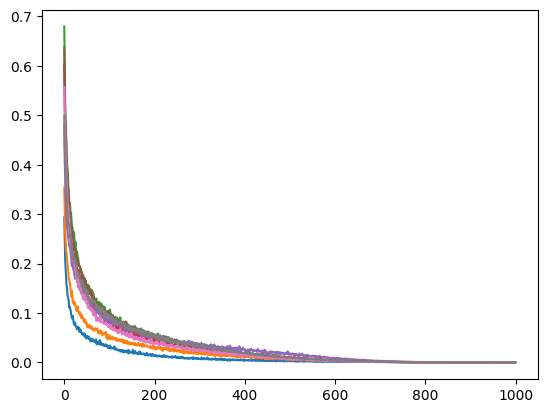

In [11]:
for i in range(1):
    for j in range(8):
        plt.plot(lds_loss_array[i, :, j], color="C{}".format(j))
    # break

In [13]:
mask_array_list = []

for i in my_list:
    # print(i)
    with open('../../data/indices/50000-0.5/lds-val/sub-idx-{}.pkl'.format(i), 'rb')  as handle:
        sub_idx_train = pickle.load(handle)
    # print(len(sub_idx_train))
    mask_array = np.in1d(idx_train, sub_idx_train)
        
    mask_array_list.append(mask_array)
    
lds_mask_array = np.stack(mask_array_list)
lds_mask_array.shape

(64, 50000)

In [14]:
lds_testset_correctness = lds_loss_array.mean(axis=1)
lds_testset_correctness.shape

(64, 1000)

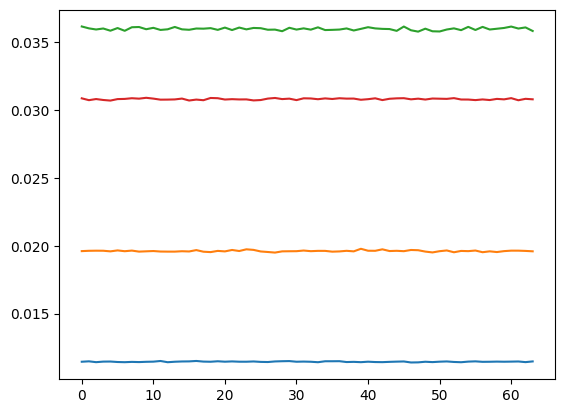

In [15]:
for j in range(4):
    plt.plot(lds_testset_correctness[:, j], color="C{}".format(j))
    # break
# plt.ylim(0.15, 0.2)

In [16]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
margins = lds_testset_correctness
infl_est_ = -scores_list[0]
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

# tmp_1 = rs

Correlation: 0.027 (avg p value 0.485252)


In [17]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
margins = lds_testset_correctness
infl_est_ = -scores_list[1]
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

# tmp_1 = rs

Correlation: 0.127 (avg p value 0.360384)


In [18]:
import matplotlib.pyplot as plt
from scipy.stats import bootstrap

In [19]:
res_list = []
for i in range(2):
    print(i)
    def my_statistics(data):
        # print(data)
        # print(len(data))
        margins = lds_testset_correctness[data]
        infl_est_ = -scores_list[i]
        # infl_est_ = -tmp
        preds = lds_mask_array[data] @ infl_est_.T
        ####
        rs = []
        ps = []
        for ind in range(1000):
            r, p = spearmanr(preds[:, ind], margins[:, ind])
            # r, p = pearsonr(preds[:, ind], margins[:, ind])
            rs.append(r)
            ps.append(p)
        
        rs, ps = np.array(rs), np.array(ps)
        # print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')
    
        return rs.mean()     

    data = (list(range(64)), )  # samples must be in a sequence
    res = bootstrap(data, my_statistics, 
                    n_resamples=64, # 够了估计
                    batch=128,
                    confidence_level=0.95,
                    random_state=42)

    print(res.confidence_interval)
    
    print(res.confidence_interval.low.round(3))
    print(res.confidence_interval.high.round(3))

    res_list.append(res)
    # break

0
ConfidenceInterval(low=0.019276483494842636, high=0.03628870088989212)
0.019
0.036
1
ConfidenceInterval(low=0.12094710145765955, high=0.13629014138088416)
0.121
0.136


In [20]:
[[res.confidence_interval.low, res.confidence_interval.high, res.bootstrap_distribution, res.standard_error] for res in res_list]

[[0.019276483494842636,
  0.03628870088989212,
  array([0.02835395, 0.03827241, 0.02552598, 0.02076449, 0.01721067,
         0.02944235, 0.02599095, 0.03070433, 0.03103148, 0.02862859,
         0.03176849, 0.02569215, 0.01704241, 0.02739527, 0.0199057 ,
         0.01996109, 0.02664672, 0.03117673, 0.02657101, 0.03623317,
         0.03335191, 0.02676385, 0.03151462, 0.0303602 , 0.03630129,
         0.02929602, 0.02266773, 0.02675423, 0.02956141, 0.02865364,
         0.02921483, 0.02992814, 0.02876305, 0.02623202, 0.02398347,
         0.02593054, 0.02442813, 0.02091469, 0.0239171 , 0.02517886,
         0.02677903, 0.02362221, 0.02539769, 0.02472931, 0.0318153 ,
         0.03343663, 0.02665756, 0.03489871, 0.02369056, 0.0192158 ,
         0.03177496, 0.02929134, 0.03290688, 0.0281653 , 0.02398242,
         0.03242178, 0.02735333, 0.02105527, 0.0333355 , 0.02258837,
         0.02805165, 0.02708277, 0.02762982, 0.02040026]),
  0.004650045372721358],
 [0.12094710145765955,
  0.13629014138088

In [21]:
with open("./val_res_list.pkl", 'wb') as handle:
    pickle.dump([[res.confidence_interval.low, res.confidence_interval.high, res.bootstrap_distribution, res.standard_error] for res in res_list],
                handle)

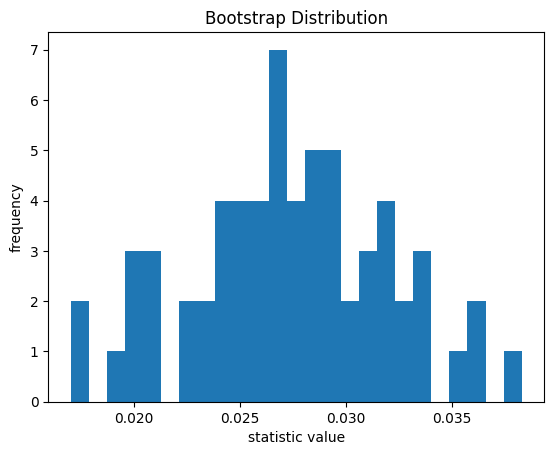

In [22]:
fig, ax = plt.subplots()
ax.hist(res_list[0].bootstrap_distribution, bins=25)
ax.set_title('Bootstrap Distribution')
ax.set_xlabel('statistic value')
ax.set_ylabel('frequency')
plt.show()